In [ ]:
import os 
import random
import librosa
import librosa.display
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import IPython.display as ipd
import matplotlib.pyplot as plt
from python_speech_features import mfcc, logfbank

import warnings
warnings.filterwarnings('ignore')

from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

from keras.models import load_model

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/p2m/UrbanSound8K/metadata/UrbanSound8K.csv')

In [ ]:
df = df.rename(columns = {'class': 'className'},inplace=False)
classes = list(np.unique(df.className))
classes

['air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music']

In [ ]:
len = []
for f in df.index:
  #signal, sampling_rate = librosa.load('/content/drive/MyDrive/Colab Notebooks/DataSetAudio/' + str(df['slice_file_name'][f]))
  len.append((df['end'][f] - df['start'][f]))
df['length'] = len
df

,slice_file_name,fsID,start,end,salience,fold,classID,className,length
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,0.317551
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,4.000000
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,4.000000
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,4.000000
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,4.000000
...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,4.000000
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,2.142545
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,3.505983
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,2.532098


In [ ]:
class_dist = df.groupby(['className'])['length'].mean()
class_dist

className
air_conditioner     3.994929
car_horn            2.456768
children_playing    3.961875
dog_bark            3.148750
drilling            3.548244
engine_idling       3.935993
gun_shot            1.649188
jackhammer          3.610975
siren               3.910335
street_music        4.000000
Name: length, dtype: float64

In [ ]:
n_samples = int(df['length'].sum() / 0.1)

prob_dist = class_dist / class_dist.sum()

choices = np.random.choice(class_dist.index, p=prob_dist)

In [ ]:
# DATA SPLIT

train_datagen = ImageDataGenerator(rescale = 1./255, 
                             shear_range = 0.2, 
                             zoom_range = 0.2, 
                             horizontal_flip = True,
                             validation_split = 0.2)
    
train_set = train_datagen.flow_from_directory('/content/drive/MyDrive/p2m/DataSetImage', 
                                          target_size = (224, 224), 
                                          batch_size = 32,
                                          subset='training',
                                          class_mode = 'categorical')
    
validation_set = train_datagen.flow_from_directory('/content/drive/MyDrive/p2m/DataSetImage', 
                                          target_size = (224, 224), 
                                          batch_size = 32,
                                          subset='validation',
                                          class_mode = 'categorical')

Found 1668 images belonging to 4 classes.
Found 414 images belonging to 4 classes.


In [ ]:
#CNN_MODEL

# re-size all the images to this
IMAGE_SIZE = [224, 224]

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
      layer.trainable = False
    
# our layers 
x = Flatten()(vgg.output)
    
x = Dense(1000, activation='relu')(x)
    
x = Dense(128, activation='relu')(x)
    
x = Dense(64, activation='relu')(x)    
    
prediction = Dense(4, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
r = model.fit_generator(train_set, 
                        validation_data = validation_set, 
                        epochs = 50, 
                        steps_per_epoch = train_set.samples // 32,
                        validation_steps = validation_set.samples // 32)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

52/52 [==============================] - 13s 253ms/step - loss: 0.2626 - accuracy: 0.9034 - val_loss: 1.6044 - val_accuracy: 0.5573
Epoch 33/50
52/52 [==============================] - 13s 251ms/step - loss: 0.2832 - accuracy: 0.8894 - val_loss: 0.8735 - val_accuracy: 0.7240
Epoch 34/50
52/52 [==============================] - 13s 252ms/step - loss: 0.2239 - accuracy: 0.9150 - val_loss: 0.7777 - val_accuracy: 0.7005
Epoch 35/50
52/52 [==============================] - 13s 251ms/step - loss: 0.2348 - accuracy: 0.9126 - val_loss: 0.8533 - val_accuracy: 0.7005
Epoch 36/50
52/52 [==============================] - 13s 253ms/step - loss: 0.2385 - accuracy: 0.9089 - val_loss: 0.8671 - val_accuracy: 0.6771
Epoch 37/50
52/52 [==============================] - 13s 252ms/step - loss: 0.2118 - accuracy: 0.9242 - val_loss: 0.8641 - val_accuracy: 0.7266
Epoch 38/50
52/52 [==============================] - 13s 253ms/step - loss: 0.2257 - accuracy: 0.9114 - val_loss: 1.1082 - val_accuracy: 0.6484
Epoc

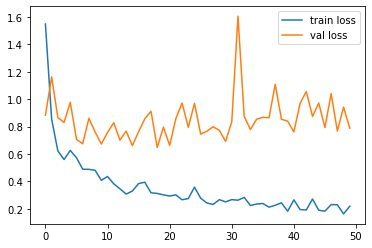

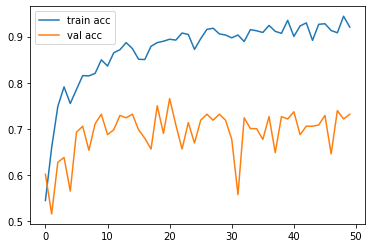

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
model.save('alarm_sound_classification_model2.h5')